# NYC Taxi Fare & Duration
## Model Training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wget
import pickle
import glob

sys.path.append("..")

import source.configs as configs
import preprocessing as preprocessing

# Check if we are in COLAB
IN_COLAB = 'google.colab' in sys.modules

Download dataset files (2022)

In [3]:
if IN_COLAB:
    !wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-05.parquet "../dataset"
else:
    for url in configs.START_DATASET_URLS:
        fname = url.split("/")[-1] 
        if not os.path.exists(f"../dataset/{fname}"):
            print(f"Downloading {fname}")
            wget.download(url, "../dataset")
        else:
            print(f"Skipping {fname}")

Skipping yellow_tripdata_2022-05.parquet


In [4]:
files_list = glob.glob("../dataset/*.parquet")
dataset_list = []
for file in files_list:
    print(f"Reading {file}")
    df_month = pd.read_parquet(file)
    dataset_list.append(df_month)
print("Pandas concat...")
dataset = pd.concat(dataset_list, axis=0, ignore_index=True)
print("Done!")

Reading ../dataset/yellow_tripdata_2022-05.parquet
Pandas concat...
Done!


In [6]:
print("Add targets")
dataset = preprocessing.add_targets(dataset)
print("Add features")
dataset, avg_speed_dict = preprocessing.add_features(dataset)
pickle.dump(avg_speed_dict, open("avg_speed_dict.model", "wb"))
print(avg_speed_dict)
print("Process outliers")
dataset = preprocessing.process_outliers(dataset, "delete")
print("fill na values")
dataset = preprocessing.fill_na_values(dataset)
print("Done!")

Add targets
Add features
Building average speed dictionary
{'avg_speed': {0: 0.2730204866845607, 1: 0.275671222171684, 2: 0.2755159533039431, 3: 0.28891394455508135, 4: 0.3510557166783407, 5: 0.37421473000338096, 6: 0.29503957535347514, 7: 0.23304783318637587, 8: 0.20043363360208405, 9: 0.19323035851528303, 10: 0.1868952498384387, 11: 0.18092146970765113, 12: 0.1758728991294986, 13: 0.17626533822871762, 14: 0.17110675827920568, 15: 0.16903225707362451, 16: 0.1686584532433768, 17: 0.1702160249544352, 18: 0.1784481237619191, 19: 0.19930868637253138, 20: 0.21652716093617438, 21: 0.23010893154516793, 22: 0.24074062991958606, 23: 0.25788477138905136}}
Process outliers
fill na values
Done!


### Features
* trip_distance
* hour_of_day: Extracted from tpep_pickup_datetime
* avg_speed: trip_distance / trip_duration. It is stored to use during inference.
* trip_d2: Trip distance squared
* rush_hour: Extracted from tpep_pickup_datetime. Binary.
### Targets
* fare_amount
* trip_duration

In [7]:
columns = preprocessing.features + preprocessing.targets
train_dataset = preprocessing.select_features(dataset, columns)
train_dataset, encoders = preprocessing.create_one_hot_encodings(train_dataset, columns)
pickle.dump(encoders, open('encoders.model', 'wb'))

In [8]:
train_dataset.columns.to_list()

['trip_distance',
 'hour_of_day',
 'rush_hour',
 'day_of_week',
 'trip_d2',
 'avg_speed',
 'fare_amount',
 'trip_duration']

In [9]:
for col in train_dataset.isna().sum():
    assert col==0
print("Ok, no NAs in train dataset!")

Ok, no NAs in train dataset!


In [10]:
train_dataset.describe()

,trip_distance,hour_of_day,rush_hour,day_of_week,trip_d2,avg_speed,fare_amount,trip_duration
count,3.289664e+06,3.289664e+06,3.289664e+06,3.289664e+06,3.289664e+06,3.289664e+06,3.289664e+06,3.289664e+06
mean,3.546120e+00,1.421627e+01,3.194651e-01,2.906948e+00,3.086053e+01,2.022320e-01,1.448234e+01,1.613262e+01
std,4.276163e+00,5.748154e+00,4.662695e-01,1.998258e+00,7.831490e+01,3.697597e-01,1.193054e+01,1.260353e+01
min,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,1.175779e-03,2.500000e+00,2.500000e-01
25%,1.170000e+00,1.100000e+01,0.000000e+00,1.000000e+00,1.368900e+00,1.288889e-01,7.000000e+00,7.733333e+00
50%,1.940000e+00,1.500000e+01,0.000000e+00,3.000000e+00,3.763600e+00,1.708401e-01,1.050000e+01,1.260000e+01
75%,3.610000e+00,1.900000e+01,1.000000e+00,5.000000e+00,1.303210e+01,2.351680e-01,1.600000e+01,2.025000e+01
max,2.500000e+01,2.300000e+01,1.000000e+00,6.000000e+00,6.250000e+02,8.480000e+01,7.500000e+01,9.000000e+01


In [11]:
train_dataset.columns.to_list()

['trip_distance',
 'hour_of_day',
 'rush_hour',
 'day_of_week',
 'trip_d2',
 'avg_speed',
 'fare_amount',
 'trip_duration']

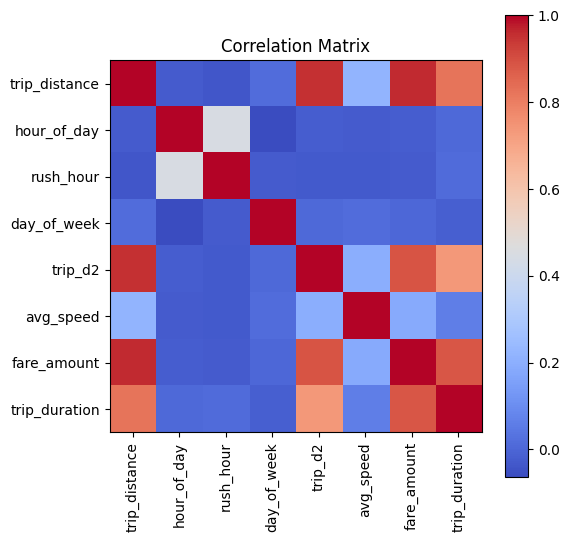

In [12]:
correlation_matrix = train_dataset.corr()
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Correlation Matrix')
plt.xticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.columns, rotation=90)
plt.yticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.columns)
plt.show()

## Model Training

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Split dataset

In [14]:
# Split features and targets
X, y = preprocessing.split_dataset(train_dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_td = y_train["trip_duration"]
y_train_fa = y_train["fare_amount"]

## LINEAR MODEL

In [15]:
from sklearn.linear_model import LinearRegression
linreg_model_td = LinearRegression(n_jobs=-1)
linreg_model_fa = LinearRegression(n_jobs=-1)

In [16]:
print("Fit model TD")
linreg_model_td.fit(X_train, y_train_td.values.ravel());
print("Fit model FA")
linreg_model_fa.fit(X_train, y_train_fa.values.ravel());
print("Done!")

Fit model TD
Fit model FA
Done!


In [17]:
test_predictions_fa = linreg_model_fa.predict(X_test)
test_predictions_td = linreg_model_td.predict(X_test)

y_test_td = y_test["trip_duration"]
mse_td = mean_squared_error(y_test_td, test_predictions_td)**0.5
r2_td = r2_score(y_test_td, test_predictions_td)
print(f"Trip duration MSE: {mse_td} minutes")
print(f"Trip duration R2: {r2_td}")

y_test_fa = y_test["fare_amount"]
mse_fa = mean_squared_error(y_test_fa, test_predictions_fa)**0.5
r2_fa = r2_score(y_test_fa, test_predictions_fa)
print(f"Fare amount MSE: {mse_fa} $")
print(f"Fare amount R2: {r2_fa}")

Trip duration MSE: 6.653568400598045 minutes
Trip duration R2: 0.7210147699353662
Fare amount MSE: 3.1388385616615886 $
Fare amount R2: 0.9307972547552438


In [18]:
pickle.dump(linreg_model_fa, open('linreg_model_fa.model', 'wb'))
pickle.dump(linreg_model_td, open('linreg_model_td.model', 'wb'))

## MODEL RANDOM FOREST

In [19]:
ENABLE_RF = False

In [20]:
if ENABLE_RF:
    from sklearn.ensemble import RandomForestRegressor
    rf_model_td = RandomForestRegressor(n_jobs=-1,
                                        n_estimators=5)
    rf_model_fa = RandomForestRegressor(n_jobs=-1,
                                        n_estimators=5)

In [21]:
if ENABLE_RF:
    print("Fit model TD")
    rf_model_td.fit(X_train, y_train_td.values.ravel());
    print("Fit model FA")
    rf_model_fa.fit(X_train, y_train_fa.values.ravel());
    print("Done!")

In [22]:
if ENABLE_RF:
    global_importances = pd.Series(rf_model_td.feature_importances_, index=X_train.columns)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Trip duration - feature importance")

    global_importances = pd.Series(rf_model_fa.feature_importances_, index=X_train.columns)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Fare amount - feature importance")

In [23]:
if ENABLE_RF:
    test_predictions_fa = rf_model_fa.predict(X_test)
    test_predictions_td = rf_model_td.predict(X_test)

    y_test_td = y_test["trip_duration"]
    mse_td = mean_squared_error(y_test_td, test_predictions_td)**0.5
    r2_td = r2_score(y_test_td, test_predictions_td)
    print(f"Trip duration MSE: {mse_td} minutes")
    print(f"Trip duration R2: {r2_td}")

    y_test_fa = y_test["fare_amount"]
    mse_fa = mean_squared_error(y_test_fa, test_predictions_fa)**0.5
    r2_fa = r2_score(y_test_fa, test_predictions_fa)
    print(f"Fare amount MSE: {mse_fa} $")
    print(f"Fare amount R2: {r2_fa}")

In [24]:
if ENABLE_RF:
    pickle.dump(rf_model_fa, open('rf_model_fa.model', 'wb'))
    pickle.dump(rf_model_td, open('rf_model_td.model', 'wb'))

## MODEL LIGHT GBM

In [25]:
print("Model LightGBM")
import lightgbm as lgb

train_data_lgb_td = lgb.Dataset(X_train, label=y_train_td)
train_data_lgb_fa = lgb.Dataset(X_train, label=y_train_fa)
params = {
    "objective": "regression",  # 'regression' for regression problems
    "metric": "rmse",  # Root Mean Squared Error for evaluation
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "num_leaves": 10,  # Maximum number of leaves in one tree
    "learning_rate": 0.05,  # Learning rate
    "feature_fraction": 0.9,  # Fraction of features to be used in each iteration
    "bagging_fraction": 0.8,  # Fraction of data to be used for bagging
    "bagging_freq": 5,  # Frequency for bagging
    "verbose": 1,  # Verbosity (0: silent, 1: progress bar, 2: print all)
}
num_rounds = 100  # Number of boosting rounds (iterations)

Model LightGBM


In [26]:
print("Training LGBM")
print("Fit model TD")
lgbm_model_td = lgb.train(params, train_data_lgb_td, num_rounds)
print("Fit model FA")
lgbm_model_fa = lgb.train(params, train_data_lgb_fa, num_rounds)
print("Done!")

Training LGBM
Fit model TD
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 2631731, number of used features: 6
[LightGBM] [Info] Start training from score 16.137781
Fit model FA
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 2631731, number of used features: 6
[LightGBM] [Info] Start training from score 14.486215
Done!


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

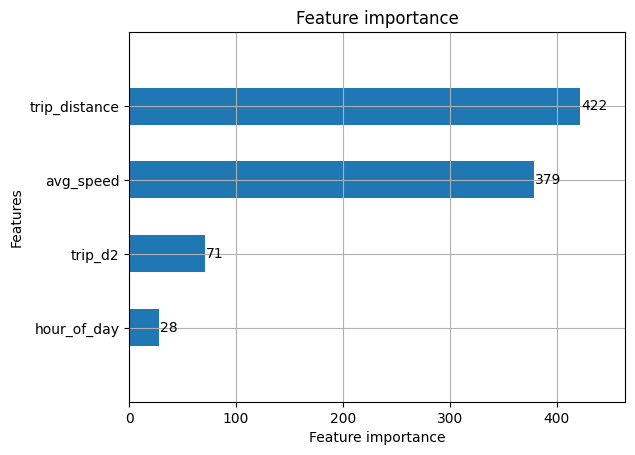

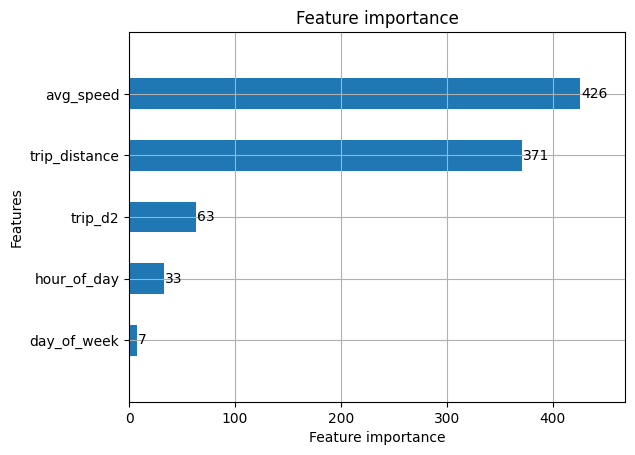

In [27]:
lgb.plot_importance(lgbm_model_fa, height=.5)
lgb.plot_importance(lgbm_model_td, height=.5)

In [28]:
test_predictions_fa = lgbm_model_fa.predict(X_test)
test_predictions_td = lgbm_model_td.predict(X_test)

y_test_td = y_test["trip_duration"]
mse_td = mean_squared_error(y_test_td, test_predictions_td)**0.5
r2_td = r2_score(y_test_td, test_predictions_td)
print(f"Trip duration RMSE: {mse_td} minutes")
print(f"Trip duration R2: {r2_td}")

y_test_fa = y_test["fare_amount"]
mse_fa = mean_squared_error(y_test_fa, test_predictions_fa)**0.5
r2_fa = r2_score(y_test_fa, test_predictions_fa)
print(f"Fare amount RMSE: {mse_fa} $")
print(f"Fare amount R2: {r2_fa}")


Trip duration RMSE: 1.168761590817777 minutes
Trip duration R2: 0.9913915725920558
Fare amount RMSE: 2.293982483470859 $
Fare amount R2: 0.9630371407143166


In [29]:
lgbm_model_fa.save_model('lgbm_model_fa.model')
lgbm_model_td.save_model('lgbm_model_td.model')

# Inference

In [30]:
model_prefix = "lgbm"
model_name_td = f"{model_prefix}_model_td.model"
model_name_fa = f"{model_prefix}_model_fa.model"

print(model_name_td)
print(model_name_fa)

if model_prefix == "lgbm":
    model_td = lgb.Booster(model_file=model_name_td)
    model_fa = lgb.Booster(model_file=model_name_fa)
else:
    if os.path.exists(model_name_td):
        with open(model_name_td, "rb") as model_td_fd:
            model_td = pickle.load(model_td_fd)
    else:
        print("TD model not found!")

    if os.path.exists(model_name_fa):
        with open(model_name_fa, "rb") as model_fa_fd:
            model_fa = pickle.load(model_fa_fd)
    else:
        print("FA model not found!")

if os.path.exists("encoders.model"):
    with open("encoders.model", "rb") as encoders_file:
        encoders = pickle.load(encoders_file)
else:
    print("Encoders model not found!")

if os.path.exists("avg_speed_dict.model"):
    with open("avg_speed_dict.model", "rb") as avg_speed_dict_fd:
        avg_speed_dict = pickle.load(avg_speed_dict_fd)
else:
    print("Average speed dictionary not found!")

lgbm_model_td.model
lgbm_model_fa.model


Input

In [31]:
pickup_date="2022/05/16"
pickup_time="12:00:00"
tpep_pickup_datetime = pickup_date + " " + pickup_time
trip_distance = "1.0"

In [32]:
data = {
    "trip_distance": [float(trip_distance)], 
    "tpep_pickup_datetime": [pd.to_datetime(tpep_pickup_datetime)] }
df = pd.DataFrame(data)
df,_ = preprocessing.add_features(df, avg_speed_dict)
df.drop(columns="tpep_pickup_datetime", inplace=True)
print(avg_speed_dict)

Using pre-processed average speed dictionary
{'avg_speed': {0: 0.2730204866845607, 1: 0.275671222171684, 2: 0.2755159533039431, 3: 0.28891394455508135, 4: 0.3510557166783407, 5: 0.37421473000338096, 6: 0.29503957535347514, 7: 0.23304783318637587, 8: 0.20043363360208405, 9: 0.19323035851528303, 10: 0.1868952498384387, 11: 0.18092146970765113, 12: 0.1758728991294986, 13: 0.17626533822871762, 14: 0.17110675827920568, 15: 0.16903225707362451, 16: 0.1686584532433768, 17: 0.1702160249544352, 18: 0.1784481237619191, 19: 0.19930868637253138, 20: 0.21652716093617438, 21: 0.23010893154516793, 22: 0.24074062991958606, 23: 0.25788477138905136}}


In [33]:
for encoder_model in encoders:
    encoder, col = encoder_model
    array = pd.DataFrame(df[col].values.reshape(1,-1), columns=[col])
    encoded_data = encoder.transform(array)
    encoded_data = encoded_data.toarray()
    encoded_df = pd.DataFrame(encoded_data, 
                            columns=encoder.get_feature_names_out([col])
    )
    df = pd.concat([df, encoded_df], axis=1, join="inner")
    df.drop(columns=col, inplace=True)

In [34]:
df.head()

,trip_distance,hour_of_day,rush_hour,day_of_week,trip_d2,avg_speed
0,1.0,12,0,0,1.0,0.175873


In [35]:
y_fa = round(model_fa.predict(df)[0],2)
y_td = int(model_td.predict(df)[0])
print(f"Trip duration: {y_td} minutes")
print(f"Fare amount: $ {y_fa}")

Trip duration: 6 minutes
Fare amount: $ 6.18
